

# 使用CTC改进CNN



In [0]:
## report 1: 使用offline+极少的数据集做pre-train
10*16 个数据量，adadelta, 切分为15份进入到系统中，输出15X37维的数据
结果：loss停在 15.4
原因分析：特征过于模糊？conv太浅

### 改动：1.1 - 增加三层深度，然后retrain
结果：loss仍然是15.4以上，50epoch是14.96.



In [2]:
# run once
!pip install captcha
!pip install tqdm

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5,1,u'HJFQ')

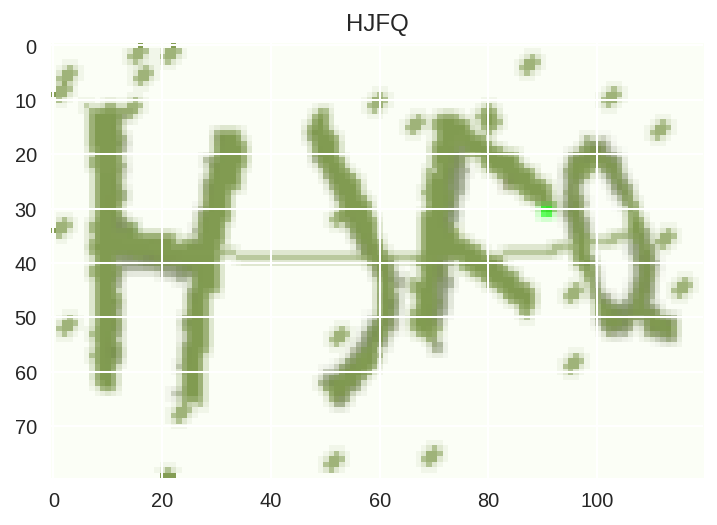

In [3]:
# feel what is captcha
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import errno
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 120, 80, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)

random_str = ''.join([random.choice(characters) for j in range(n_len)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [0]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if  exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [6]:
from keras.models import *
from keras.layers import *
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
  
rnn_size = 16

def build_model():
  input_tensor = Input((width, height, 3))
  x = input_tensor
  for i in range(3):
      x = Convolution2D(32, (3, 3), activation='relu', padding="same")(x)
      x = Convolution2D(32, (3, 3), activation='relu', padding="same")(x)
      x = MaxPooling2D(pool_size=(2, 2))(x)

  conv_shape = x.get_shape()
  x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

  x = Dense(32, activation='relu')(x)

  gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
  gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
               init='he_normal', name='gru1_b')(x)
  gru1_merged = merge([gru_1, gru_1b], mode='sum')

  gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
  gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
               init='he_normal', name='gru2_b')(gru1_merged)
  x = merge([gru_2, gru_2b], mode='concat')
  x = Dropout(0.25)(x)
  x = Dense(n_class + 1, init='he_normal', activation='softmax')(x)
  base_model = Model(input=input_tensor, output=x)

  labels = Input(name='the_labels', shape=[n_len], dtype='float32')
  input_length = Input(name='input_length', shape=[1], dtype='int64')
  label_length = Input(name='label_length', shape=[1], dtype='int64')
  loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                    name='ctc')([x, labels, input_length, label_length])
  return Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out]), base_model, conv_shape

model, base_model, conv_shape = build_model()
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(16, return_sequences=True, kernel_initializer="he_normal", name="gru1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(16, go_backwards=True, kernel_initializer="he_normal", name="gru1_b", return_sequences=True)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `GRU` call to the Keras 2 A

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 120, 80, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 80, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 120, 80, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 60, 40, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [0]:
# generate offline data
def generate_offline_data(rootdir, npy_file_count = 10, count_each_npy = 128):
  start_time = time.time()
  print("start to generate, total count - " + str(npy_file_count * count_each_npy))
  for t in range(0,npy_file_count):
    X = np.zeros((count_each_npy, height, width, 3), dtype=np.uint8)
    y = [np.zeros((count_each_npy, n_class), dtype=np.uint8) for i in range(n_len)]
    
    for i in range(count_each_npy):
       random_str = ''.join([random.choice(characters) for j in range(n_len)])
       X[i] = generator.generate_image(random_str)
       for j, ch in enumerate(random_str):
          y[j][i, :] = 0
          y[j][i, characters.find(ch)] = 1
          
    np.save(rootdir + str(t) + ".npy", [X, y])

  elapsed_time = time.time() - start_time
  print("generate done, total count - " + str(npy_file_count * count_each_npy) + ", time used " + str(elapsed_time) + "s")

In [5]:
train_dir="./data/train/"
val_dir="./data/val/"

train_npy_file_count = 10
val_npy_file_count = 3
count_each_npy = 128

!rm -fr "./data"
!rm -fr ${train_dir}
mkdir_p(train_dir)
!rm -fr ${val_dir}
mkdir_p(val_dir)

generate_offline_data(train_dir, npy_file_count=train_npy_file_count, count_each_npy = count_each_npy)
generate_offline_data(val_dir, npy_file_count = val_npy_file_count, count_each_npy = count_each_npy)

start to generate, total count - 1280
generate done, total count - 1280, time used 2.83413481712s
start to generate, total count - 384
generate done, total count - 384, time used 0.86102104187s


In [8]:
# review the data
!ls {train_dir}
!ls {val_dir}

[X, y] = np.load("./data/train/0.npy")
print(X.shape)
print(y[0].shape)
print(y[0])

0.npy  1.npy  2.npy  3.npy  4.npy  5.npy  6.npy  7.npy	8.npy  9.npy
0.npy  1.npy  2.npy
(128, 80, 120, 3)
(128, 36)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]]


In [0]:
# 数据生成器 - 注意做了倒置
def gen(batch_size=16):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(n_len)])
            X[i] = np.array(generator.generate_image(random_str)).transpose(1, 0, 2)
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[1] - 2), 
               np.ones(batch_size)*n_len], np.ones(batch_size)
        
def offline_gen(rootdir, npy_file_count = 10, count_each_npy = 128, batch_size = 16):
  batch_idx = 0
  while True:
      [X_all, y_all] = np.load(rootdir + str(batch_idx) + ".npy")
      index_array = np.random.permutation(count_each_npy)
      for i in range(count_each_npy/batch_size):
        idx = index_array[(i * batch_size):((i+1) * batch_size)]
        X = X_all[idx]
        y = np.argmax(np.array([y_all[j][idx] for j in range(n_len)]),axis=2).transpose(1,0)
        yield [X.transpose(0, 2 ,1, 3), y, np.ones(batch_size)*int(conv_shape[1] - 2), np.ones(batch_size)*n_len], np.ones(batch_size)
      batch_idx += 1
      batch_idx %= npy_file_count
      

In [9]:
# 可视化offline的数据 - 注意做了倒置
[X,y,labels,input_length],label_length = next(offline_gen(train_dir, count_each_npy = count_each_npy))
print ("X,y,labels, input_length, label_length", X.shape, y.shape,labels.shape, input_length.shape, label_length.shape)
print "y0", y[0]
print labels
print input_length
print label_length

def decode(y):
    return ''.join([characters[x] for x in y])
  
plt.imshow(X[0].transpose(1,0,2))
plt.title(decode(y[0]))

NameError: ignored

('X,y,labels, input_length, label_length', (2, 120, 80, 3), (2, 4), (2,), (2,), (2,))
y0 [12 23 34 10]
[13. 13.]
[4. 4.]
[1. 1.]


Text(0.5,1,u'CNYA')

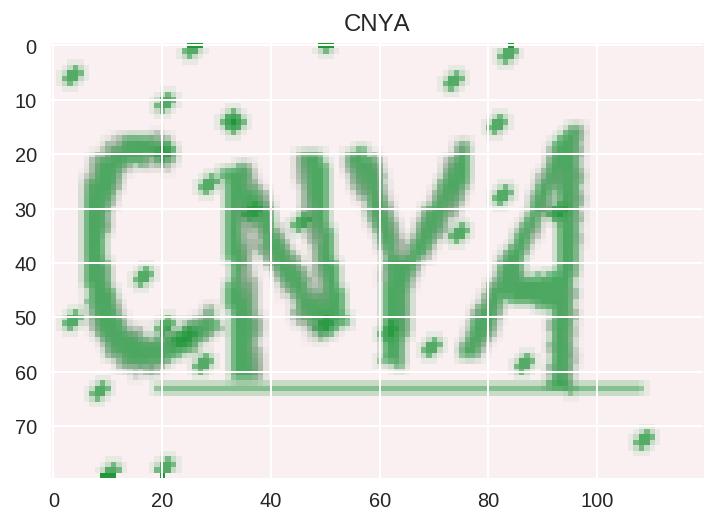

In [13]:
# 可视化online的数据 - 注意做了倒置
def decode(y):
    return ''.join([characters[x] for x in y])

[X, y, labels, input_length], label_length = next(gen(2))
print ("X,y,labels, input_length, label_length", X.shape, y.shape,labels.shape, input_length.shape, label_length.shape)
print "y0", y[0]
print labels
print input_length
print label_length

plt.imshow(X[0].transpose(1,0,2))
plt.title(decode(y[0]))

In [0]:
from keras.callbacks import *

def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen()
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        ctc_decode = K.ctc_decode(y_pred[:,2:,:], 
                                  input_length=np.ones(shape[0])*shape[1])[0][0]
        out = K.get_value(ctc_decode)[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print 'acc: %f%%'%acc

evaluator = Evaluate()

In [0]:
from keras.callbacks import TensorBoard
batch_size = 16
tbCallBack = TensorBoard(log_dir='./log',
                         write_graph=True,
                         write_grads=True,
                         batch_size=batch_size,
                         write_images=True)

In [16]:
model.fit_generator(offline_gen(train_dir, npy_file_count = train_npy_file_count, count_each_npy = count_each_npy), 
                    samples_per_epoch=128, nb_epoch=50,
                    callbacks=[EarlyStopping(patience=10), evaluator, tbCallBack],
                    validation_data=offline_gen(val_dir, npy_file_count = val_npy_file_count, count_each_npy = count_each_npy), 
                    nb_val_samples=128)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_data=<generator..., steps_per_epoch=128, epochs=50, callbacks=[<keras.ca..., validation_steps=128)`
  """


Epoch 1/50
128/128 [==============================] - 28s 221ms/step - loss: 17.8033 - val_loss: 15.8685

acc: 0.000000%
Epoch 2/50
128/128 [==============================] - 25s 197ms/step - loss: 15.9193 - val_loss: 15.8411

acc: 0.000000%
Epoch 3/50
128/128 [==============================] - 25s 197ms/step - loss: 15.8936 - val_loss: 15.8146

acc: 0.000000%
Epoch 4/50
 53/128 [===========>..................] - ETA: 11s - loss: 15.8641

128/128 [==============================] - 25s 198ms/step - loss: 15.8737 - val_loss: 15.8298

acc: 0.000000%
Epoch 5/50
128/128 [==============================] - 26s 200ms/step - loss: 15.8528 - val_loss: 15.8252

acc: 0.000000%
Epoch 6/50
128/128 [==============================] - 25s 197ms/step - loss: 15.8579 - val_loss: 15.7996

acc: 0.000000%
Epoch 7/50
 73/128 [================>.............] - ETA: 8s - loss: 15.8227

128/128 [==============================] - 26s 200ms/step - loss: 15.8230 - val_loss: 15.7640

acc: 0.000000%
Epoch 8/50
128/128 [==============================] - 26s 202ms/step - loss: 15.8081 - val_loss: 15.7699

acc: 0.000000%
Epoch 9/50
128/128 [==============================] - 26s 206ms/step - loss: 15.7565 - val_loss: 15.6466

acc: 0.000000%
Epoch 10/50
 75/128 [================>.............] - ETA: 8s - loss: 15.7139

128/128 [==============================] - 27s 208ms/step - loss: 15.7027 - val_loss: 15.5952

acc: 0.000000%
Epoch 11/50
128/128 [==============================] - 26s 207ms/step - loss: 15.6240 - val_loss: 15.4268

acc: 0.000000%
Epoch 12/50
128/128 [==============================] - 26s 207ms/step - loss: 15.5273 - val_loss: 15.5240

acc: 0.000000%
Epoch 13/50
 75/128 [================>.............] - ETA: 8s - loss: 15.4307

128/128 [==============================] - 27s 208ms/step - loss: 15.4041 - val_loss: 15.2637

acc: 0.000000%
Epoch 14/50
128/128 [==============================] - 26s 206ms/step - loss: 15.3453 - val_loss: 15.0779

acc: 0.000000%
Epoch 15/50
128/128 [==============================] - 27s 207ms/step - loss: 15.2434 - val_loss: 15.0177

acc: 0.000000%
Epoch 16/50
 75/128 [================>.............] - ETA: 8s - loss: 15.2144

128/128 [==============================] - 26s 206ms/step - loss: 15.1918 - val_loss: 15.0012

acc: 0.000000%
Epoch 17/50
128/128 [==============================] - 27s 208ms/step - loss: 15.1292 - val_loss: 14.9836

acc: 0.000000%
Epoch 18/50
128/128 [==============================] - 27s 208ms/step - loss: 15.1094 - val_loss: 14.9758

acc: 0.000000%
Epoch 19/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0718

128/128 [==============================] - 27s 208ms/step - loss: 15.0613 - val_loss: 14.9737

acc: 0.000000%
Epoch 20/50
128/128 [==============================] - 27s 209ms/step - loss: 15.0895 - val_loss: 14.9553

acc: 0.000000%
Epoch 21/50
128/128 [==============================] - 27s 210ms/step - loss: 15.0781 - val_loss: 14.9717

acc: 0.000000%
Epoch 22/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0543

128/128 [==============================] - 27s 211ms/step - loss: 15.0510 - val_loss: 14.9441

acc: 0.000000%
Epoch 23/50
128/128 [==============================] - 26s 207ms/step - loss: 15.0594 - val_loss: 14.9383

acc: 0.000000%
Epoch 24/50
128/128 [==============================] - 26s 207ms/step - loss: 15.0142 - val_loss: 14.9396

acc: 0.000000%
Epoch 25/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0442

128/128 [==============================] - 27s 207ms/step - loss: 15.0433 - val_loss: 14.9518

acc: 0.000000%
Epoch 26/50
128/128 [==============================] - 27s 207ms/step - loss: 15.0258 - val_loss: 15.0011

acc: 0.000000%
Epoch 27/50
128/128 [==============================] - 26s 207ms/step - loss: 15.0204 - val_loss: 14.9522

acc: 0.000000%
Epoch 28/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0515

128/128 [==============================] - 26s 206ms/step - loss: 15.0385 - val_loss: 14.9423

acc: 0.000000%
Epoch 29/50
128/128 [==============================] - 26s 206ms/step - loss: 14.9949 - val_loss: 14.9521

acc: 0.000000%
Epoch 30/50
128/128 [==============================] - 26s 207ms/step - loss: 15.0214 - val_loss: 14.9326

acc: 0.000000%
Epoch 31/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0339

128/128 [==============================] - 26s 206ms/step - loss: 15.0200 - val_loss: 14.9400

acc: 0.000000%
Epoch 32/50
128/128 [==============================] - 27s 207ms/step - loss: 15.0061 - val_loss: 14.9510

acc: 0.000000%
Epoch 33/50
128/128 [==============================] - 26s 207ms/step - loss: 15.0138 - val_loss: 14.9564

acc: 0.000000%
Epoch 34/50
 75/128 [================>.............] - ETA: 8s - loss: 15.0148

128/128 [==============================] - 27s 208ms/step - loss: 14.9807 - val_loss: 14.9248

acc: 0.000000%
Epoch 35/50
128/128 [==============================] - 27s 207ms/step - loss: 15.0101 - val_loss: 14.9299

acc: 0.000000%
Epoch 36/50
128/128 [==============================] - 26s 207ms/step - loss: 14.9907 - val_loss: 14.9390

acc: 0.000000%
Epoch 37/50
 75/128 [================>.............] - ETA: 8s - loss: 14.9862

128/128 [==============================] - 27s 208ms/step - loss: 14.9926 - val_loss: 14.9455

acc: 0.000000%
Epoch 38/50
128/128 [==============================] - 27s 207ms/step - loss: 15.0039 - val_loss: 14.9213

acc: 0.000000%
Epoch 39/50
128/128 [==============================] - 27s 209ms/step - loss: 14.9755 - val_loss: 14.9270

acc: 0.000000%
Epoch 40/50
 75/128 [================>.............] - ETA: 8s - loss: 14.9815

128/128 [==============================] - 27s 213ms/step - loss: 14.9867 - val_loss: 14.9432

acc: 0.000000%
Epoch 41/50
128/128 [==============================] - 28s 219ms/step - loss: 14.9863 - val_loss: 14.9392

acc: 0.000000%
Epoch 42/50
128/128 [==============================] - 27s 213ms/step - loss: 14.9704 - val_loss: 14.9220

acc: 0.000000%
Epoch 43/50
 75/128 [================>.............] - ETA: 8s - loss: 14.9986

128/128 [==============================] - 28s 215ms/step - loss: 14.9907 - val_loss: 14.9371

acc: 0.000000%
Epoch 44/50
128/128 [==============================] - 28s 217ms/step - loss: 14.9459 - val_loss: 14.9344

acc: 0.000000%
Epoch 45/50
128/128 [==============================] - 27s 214ms/step - loss: 14.9934 - val_loss: 14.9341

acc: 0.000000%
Epoch 46/50
 75/128 [================>.............] - ETA: 8s - loss: 14.9822

128/128 [==============================] - 27s 214ms/step - loss: 14.9759 - val_loss: 14.9332

acc: 0.000000%
Epoch 47/50
128/128 [==============================] - 27s 214ms/step - loss: 14.9622 - val_loss: 14.9295

acc: 0.000000%
Epoch 48/50
128/128 [==============================] - 28s 215ms/step - loss: 14.9625 - val_loss: 15.0472

acc: 0.000000%


[(16, 'G'),
 (7, '7'),
 (16, 'G'),
 (16, 'G'),
 (7, '7'),
 (7, '7'),
 (7, '7'),
 (7, '7'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (28, 'S'),
 (7, '7'),
 (28, 'S'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (28, 'S'),
 (28, 'S'),
 (28, 'S'),
 (7, '7'),
 (16, 'G'),
 (16, 'G'),
 (7, '7'),
 (16, 'G'),
 (16, 'G'),
 (14, 'E'),
 (7, '7'),
 (7, '7'),
 (23, 'N'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (14, 'E'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (28, 'S'),
 (16, 'G'),
 (16, 'G'),
 (16, 'G'),
 (14, 'E'),
 (14, 'E')]

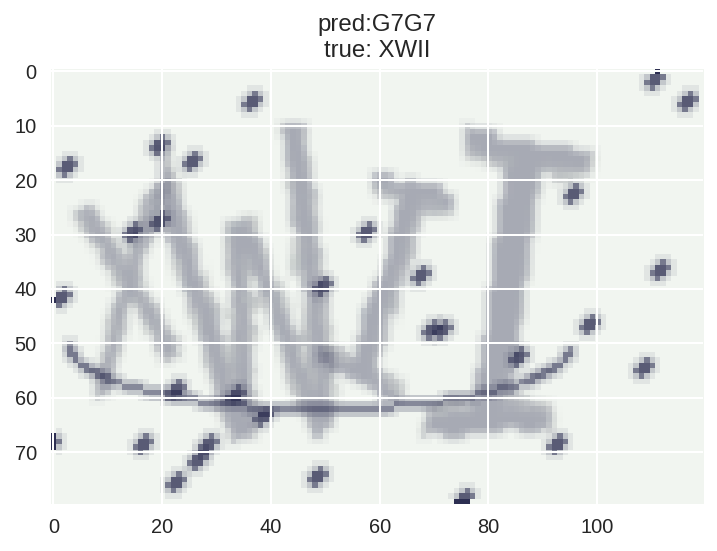

In [76]:
# test
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))